# 00. Intro & Goal

Disk Failure Prediction Notebook
* Notebook @author Lukasz Kamieniecki-Mruk, lucas.mlexp@gmail.com, http://machinelearningexp.com
* Notebook License: Creative Commons CC-BY-SA https://creativecommons.org/licenses/by-sa/4.0/
* Dataset source: https://www.backblaze.com/b2/hard-drive-test-data.html
* Dataset license: As per Backblaze statement: "You can download and use this data for free for your own purpose, all we ask is three things 1) you cite Backblaze as the source if you use the data, 2) you accept that you are solely responsible for how you use the data, and 3) you do not sell this data to anyone, it is free."
* Dataset dates: years 2015 - 2017

Your R&D task is the following:

1. Use Backblaze data for one of the most popular disk model in the dataset to build demo prediction classifier for the disk failure
2. Model should use LSTM Deep Learning networks. 
3. Model should be evaluated in details using classification report
4. Model will be successful if it will allow to find faling disk at least 2 days in advance (to ensure safe replacement)

NOTE: This notebook is CPU and memory consuming. You have been warned 🙂

# 01. Params & imports

In [1]:
import os
import gc
import fileinput
import math
import random
from random import shuffle, randrange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import regularizers,optimizers

Using TensorFlow backend.


In [2]:
# params
data_dir = "./data/"
raw_data_dir = data_dir + 'raw_data'
merged_data_dir = data_dir + 'merged_data'
pretrain_data_dir = data_dir + 'pretrain_data'
train_data_dir = data_dir + 'train_data'

# 02. Data preprocessing

It is very important what Backblaze writes on the data page (quote) : "Reported stats for the same SMART stat can vary in meaning based on the drive manufacturer and the drive model. Make sure you are comparing apples-to-apples as drive manufacturers don't generally disclose what their specific numbers mean."
Therefore, we cannot compare different disk types. For this reason, I decided to select one specific model for my analysis. The model I have selected ("ST4000DM000") is quite popular in the dataset and provides enough data for my analysis. You can try different model if you like; just make sure it provides enough data.

In [3]:
chosen_disk_model = 'ST4000DM000'
merged_file_path = merged_data_dir+'/merged_data_2015_2017.csv'

My "raw_data_dir" has 17,6 GB of data and contains 1096 CSV files. The script belowe will scan all .csv files in raw data files and will keep only first header and then only rows that contain our chosen_disk_model. As a result, we will get single merged CSV file containing only rows for our chosen_disk_model.

In [4]:
print ('Files processed',end =": ")
with open(merged_file_path, 'w') as out_file:
    first_line = True
    counter = 0
    for in_file_name in os.listdir(raw_data_dir):
        fcontent = open(os.path.join(raw_data_dir, in_file_name))
        for line in fcontent:
            if (first_line == True) or (('date,serial_number' not in line) and (chosen_disk_model in line)):
                out_file.write(line)
            first_line = False
        fcontent.close()
        if ((counter%100)==0): print (counter,end =" > ")
        counter += 1
    print ('Completed')

Files processed: 0 > 100 > 200 > 300 > 400 > 500 > 600 > 700 > 800 > 900 > 1000 > Completed


My merged file has around 8,15 GB of data. This is still a lot of data, at least for my machine. I want to create single Pandas dataframe for further processing.
We need to process data in chunks and downcast numerical data to save memory.
I decided also to drop columns with normalized data, I prefer to normalize data later myself.

In [5]:
columns_names_text = 'date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_22_normalized,smart_22_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_189_normalized,smart_189_raw,smart_190_normalized,smart_190_raw,smart_191_normalized,smart_191_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_201_normalized,smart_201_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw'
columns_names = columns_names_text.split(',')
columns_to_drop = [col for col in columns_names if '_normalized' in col]
gc.collect()

7

Be patient, this step can consume a lot of memory and be slow.

In [6]:
chunksize = 10 ** 5
chunks_list = list()
print ('Chunks: ',end ="")
for chunk in pd.read_csv(merged_file_path, header = 0 ,names=columns_names, chunksize=chunksize, low_memory=False):
    chunk = chunk.drop(columns_to_drop, axis=1)
    chunk_first_rows = chunk.iloc[:,0:4]
    chunk_num_rows = chunk.iloc[:,4:].fillna(0)
    chunk_num_rows = chunk_num_rows.astype('int64')
    chunk_num_rows = chunk_num_rows.apply(pd.to_numeric,downcast='integer')
    chunk_all = chunk_first_rows.join(chunk_num_rows)
    chunks_list.append(chunk_all)
    if ((len(chunks_list)%50)==0): print (len(chunks_list), end=" > ")
    gc.collect() 
print ('Completed')

Chunks: 50 > 100 > 150 > 200 > 250 > 300 > Completed


Now we will a) merge all chunks into one dataframe b) drop columns with empty values c) generate column with weekday and d) save it to pickle file.

In [7]:
reduced_df = pd.concat(chunks_list)
reduced_df = reduced_df.dropna(axis=1)
reduced_df['date'] = pd.to_datetime(reduced_df['date'])
reduced_df.insert(1, 'weekday', reduced_df['date'].dt.dayofweek)
reduced_df = reduced_df.sort_values(by=['serial_number','date'],axis=0)
reduced_df = reduced_df.drop(columns=['model'])
reduced_df = reduced_df.reset_index(drop=True)
reduced_df.iloc[0:5,:12]

,date,weekday,serial_number,capacity_bytes,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_8_raw
0,2016-09-10,5,S3000A9T,4000787030016,0,14415968,0,0,4,0,97797,0
1,2016-09-11,6,S3000A9T,4000787030016,1,57961664,0,0,4,0,256456,0
2,2017-06-03,5,S3000A9T,4000787030016,0,107687208,0,0,33,0,33158496,0
3,2017-06-04,6,S3000A9T,4000787030016,0,132850464,0,0,33,0,33315265,0
4,2017-06-05,0,S3000A9T,4000787030016,0,176573128,0,0,33,0,33376638,0


In [8]:
reduced_df.to_pickle(pretrain_data_dir+'/pretrain_data_01.pkl')

Let's clean some memory before further processing

In [9]:
del (reduced_df, chunks_list)
gc.collect()

80

# 03A. Training data prepration

Let's load prepared data

In [10]:
df = pd.read_pickle(pretrain_data_dir+'/pretrain_data_01.pkl')
loaded_shape = df.shape
print ("Data shape: ",loaded_shape)
df = df.sort_values(by=['serial_number','date'],axis=0,ascending=True)

Data shape:  (31414293, 50)


Hm, so we have over 31 million records. That is nice ...

Now we will aggregate data to calculate number of failed and not failed disks. As number of not failed disks is probaby much higher than number of failed disks, we can remove some npn-failed disks to reduce dataset size.

In [11]:
df_aggregate = (df[['date','serial_number','failure']].groupby('serial_number',as_index = True)
                .agg({'date':'count', 'failure':'sum'})
                .rename(columns={'date': 'date_count', 'failure': 'failure_sum'})
                .sort_values(by=['failure_sum'],axis=0,ascending=False))
df_aggregate.head(5)

,date_count,failure_sum
serial_number,,
Z305AQGZ,414,2
Z305PEAL,397,2
S300WEE9,597,2
W3005047,148,1
Z301ZQH4,312,1


As you can see, some disks failed more than once. We have to be careful when processing data.

In [12]:
all_count = df_aggregate.shape[0]
broken_count = df_aggregate[df_aggregate.iloc[:, 1] >= 1].shape[0]
print ('number of disks : ',all_count)
print ('number of failed disks: ',broken_count)
print ('percentage of broken disks: ',broken_count/all_count*100,'%' )

number of disks :  36700
number of failed disks:  2587
percentage of broken disks:  7.049046321525886 %


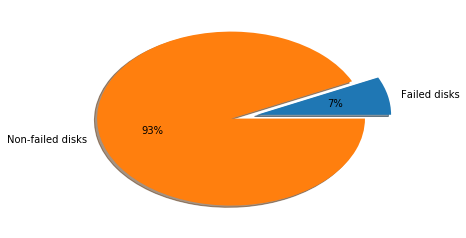

In [13]:
labels = ['Failed disks','Non-failed disks']
shares = [broken_count,all_count-broken_count] 
plt.pie(shares,explode=(0.2,0),labels=labels,autopct='%.0f%%',shadow=True,)
plt.show()

Broken disks constitute only ~7% of all disks. In order to balance classes and reduce dataset size, we can decrease number of not failed disks. The parameter num_ok_delta defines how many more not failed individual disks (than failed) we will leave in the dataset as to ensure more variability in this class.
NOTE: This step is not exactly necessary (if you have enough memory on your machine). During further processing I ensure again that number of "not failed" samples corresponds roughly to number of "failed" samples. 

In [14]:
num_ok_delta = 2000
df_broken = df_aggregate[df_aggregate['failure_sum']>0].index.values
df_ok = df_aggregate[df_aggregate['failure_sum']==0].sample(n=(df_broken.shape[0]+num_ok_delta)).index.values
selected_disks = np.concatenate((df_broken, df_ok), axis=0)
df = df.loc[df.serial_number.isin(selected_disks)]
reduced_shape = df.shape
reduced_shape

(5349516, 50)

In [15]:
print ("dataset size reduction: ",int(100*((loaded_shape[0] - reduced_shape[0])/loaded_shape[0])),"%")

dataset size reduction:  82 %


In [16]:
del df_aggregate, df_broken, df_ok, selected_disks
gc.collect()

1937

Now we will add a few empty columns that will help us in further processing.
* fails_soon - this will be our key target column. It tells "the disk will fail in the next N days (N being our parameter)" 
* seq_id - sequence is one series of disk history: from the first event in our dataset till: either last recorded event or failure. As we have noticed, some disks failed twice. They will have two different sequence ids then (one for each sequence).
* work_day - consecutive number showing number of days disk is working (for a given sequence). Numbering starts from 1.
* max_work_day - maximal work_day in a sequence. This is a helper parameter for further processing.
* final_failure - information whether disk finally failed (1) or not (0). This is also helper parameter that will help in further processing.

The "helper" parameters, although repeat the same data for a moment, will allow us to keep processing linear and avoid "nested loops/quadratic processing".

In [17]:
df = df.sort_values(by=['serial_number','date'],axis=0,ascending=True)
df.insert(5, 'fails_soon', np.nan)
df.insert(6, 'seq_id', np.nan)
df.insert(7, 'work_day', np.nan)
df.insert(8, 'max_work_day', np.nan)
df.insert(9, 'final_failure', np.nan)
df.iloc[0:5,:12]

,date,weekday,serial_number,capacity_bytes,failure,fails_soon,seq_id,work_day,max_work_day,final_failure,smart_1_raw,smart_2_raw
0,2016-09-10,5,S3000A9T,4000787030016,0,NaN,NaN,NaN,NaN,NaN,14415968,0
1,2016-09-11,6,S3000A9T,4000787030016,1,NaN,NaN,NaN,NaN,NaN,57961664,0
2,2017-06-03,5,S3000A9T,4000787030016,0,NaN,NaN,NaN,NaN,NaN,107687208,0
3,2017-06-04,6,S3000A9T,4000787030016,0,NaN,NaN,NaN,NaN,NaN,132850464,0
4,2017-06-05,0,S3000A9T,4000787030016,0,NaN,NaN,NaN,NaN,NaN,176573128,0


Now we will sort data by disk serial number and date ascending. This is very important step for next processing loop.

In [18]:
df = df.sort_values(by=['serial_number','date'],axis=0,ascending=True)

The next loop will go through the whole dataset and:
* once encounters new disk, it will set parameters specifically for beginning of a new sequence (see code)
* if continues current sequence, it will just increment current working day and set current sequence id

As a result of this script, two newly added columns will be filled in: seq_id and work_day

In [19]:
curr_serial_number = None
prev_failure = 0
observ_seq_id = 0
counter = 0
for idx,data in df.iterrows():
    if (data['serial_number'] != curr_serial_number) or (prev_failure == 1):
        curr_serial_number = data['serial_number']
        curr_work_day = 1
        observ_seq_id += 1
    else:
        curr_work_day += 1
    df.at[idx, 'seq_id'] = observ_seq_id
    df.at[idx, 'work_day'] = curr_work_day
    prev_failure = data['failure'] 
    # print status every 0.5 million rows processed
    if (counter%500000==0): print (int(counter*100/df.shape[0]),'%',end =" > ")
    counter += 1
print ("completed")

0 % > 9 % > 18 % > 28 % > 37 % > 46 % > 56 % > 65 % > 74 % > 84 % > 93 % > completed


This is our dataset head after first processing loop

In [20]:
df.iloc[0:5,:12]

,date,weekday,serial_number,capacity_bytes,failure,fails_soon,seq_id,work_day,max_work_day,final_failure,smart_1_raw,smart_2_raw
0,2016-09-10,5,S3000A9T,4000787030016,0,NaN,1.0,1.0,NaN,NaN,14415968,0
1,2016-09-11,6,S3000A9T,4000787030016,1,NaN,1.0,2.0,NaN,NaN,57961664,0
2,2017-06-03,5,S3000A9T,4000787030016,0,NaN,2.0,1.0,NaN,NaN,107687208,0
3,2017-06-04,6,S3000A9T,4000787030016,0,NaN,2.0,2.0,NaN,NaN,132850464,0
4,2017-06-05,0,S3000A9T,4000787030016,0,NaN,2.0,3.0,NaN,NaN,176573128,0


Cause this step takes a lot of time, we will save result into interim picke file. You will be able to load this interim file and rerun next steps without generating these data again.

In [21]:
df.to_pickle(pretrain_data_dir+'/pretrain_data_02.pkl')

In [22]:
df = pd.read_pickle(pretrain_data_dir+'/pretrain_data_02.pkl')

Now we need to sort data again. This time, each sequence will be sorted from last working day to first working day (in descending order). Thanks to that, our next processing script will know what happened with disk at the end - did it fail or not?

In [23]:
df = df.sort_values(by=['seq_id','work_day'],axis=0,ascending=[True, False])

These two parameters below are one of the key parameters of this excercise:
* sample_days - defines how many days we want to have in each sample (sequence) that we will feed into LSTM network. LSTMs as recurrent networks can learn from sequences and we will take advantage of that. The longer the sequence in a single sample is, the more information about potential trend we provide to the network. But also, days that are more far away from the final failure day have less guidance in SMART parameters whether disk will fail or not, so they may mislead the network. 
* predict_failure_days - defines how many days before the failure day we treat as "fails soon "days. So you can think of it also as a "warning flag" - do you want to be warned about potential failure 3, 5 or 10 days before it happens? The bigger this parameter is, the more samples we can generate for training for "failed" disks. But, the same as for previous parameter, samples more "far away" from the failure day will have less info hidden in SMART parameters about potential trend.

See the image below to understand how we will construct each sample. For LSTM networks, input has 3D structure (num_samples, timesteps, num_featutes). Each star "*" in the sample is one timestep with size of SMART num_features each.

![title](sample_structure.png "ShowMyImage")

In [24]:
sample_days = 5
predict_failure_days = 5
assert predict_failure_days >= sample_days

This script will fill columns: max_work_day, final_failure and fails_soon. It will also remove sequences of data that are smaller (shorter) than sample_days. We cannot use too short sentences to train our network. This also means that we will be abpe to predict disk failure no sooner than after having sample_days items of data.

In [25]:
prev_observ_seq_id = None
counter = 0
remove_list = []
for idx,data in df.iterrows():
    if (prev_observ_seq_id != data['seq_id']):
        max_working_day = data['work_day']
        final_failure = data['failure']
    if max_working_day >= sample_days:
        df.at[idx, 'max_work_day'] = max_working_day
        df.at[idx, 'final_failure'] = final_failure
        if (final_failure == 1) and (data['work_day'] > (max_working_day - predict_failure_days)):
            df.at[idx, 'fails_soon'] = 1
        else:
            df.at[idx, 'fails_soon'] = 0
    else:
        remove_list.append(idx)
    prev_observ_seq_id = data['seq_id']
    if (counter%500000==0): print (int(counter*100/df.shape[0]),'%',end =" > ")
    counter += 1
df = df.drop(remove_list)
df[['fails_soon','seq_id','work_day','max_work_day','final_failure']] = \
df[['fails_soon','seq_id','work_day','max_work_day','final_failure']].astype(int)
print ("completed")

0 % > 9 % > 18 % > 28 % > 37 % > 46 % > 56 % > 65 % > 74 % > 84 % > 93 % > completed


In [26]:
df.iloc[0:5,:12]

,date,weekday,serial_number,capacity_bytes,failure,fails_soon,seq_id,work_day,max_work_day,final_failure,smart_1_raw,smart_2_raw
212,2017-12-31,6,S3000A9T,4000787030016,0,0,2,211,211,0,38941024,0
211,2017-12-30,5,S3000A9T,4000787030016,0,0,2,210,211,0,43226920,0
210,2017-12-29,4,S3000A9T,4000787030016,0,0,2,209,211,0,237129448,0
209,2017-12-28,3,S3000A9T,4000787030016,0,0,2,208,211,0,107965856,0
208,2017-12-27,2,S3000A9T,4000787030016,0,0,2,207,211,0,236818080,0


And we save the interim results again.

In [27]:
df = df.sort_values(by=['seq_id','work_day'],axis=0,ascending=[True, True])
df.to_pickle(pretrain_data_dir+'/pretrain_data_03.pkl')

# 03B. LSTM Sample selection

In [60]:
df = pd.read_pickle(pretrain_data_dir+'/pretrain_data_03.pkl')
df = df.sort_values(by=['seq_id','work_day'],axis=0,ascending=[True, False])

In [61]:
gc.collect()

17066

In [62]:
df.iloc[0:5,:12]

,date,weekday,serial_number,capacity_bytes,failure,fails_soon,seq_id,work_day,max_work_day,final_failure,smart_1_raw,smart_2_raw
212,2017-12-31,6,S3000A9T,4000787030016,0,0,2,211,211,0,38941024,0
211,2017-12-30,5,S3000A9T,4000787030016,0,0,2,210,211,0,43226920,0
210,2017-12-29,4,S3000A9T,4000787030016,0,0,2,209,211,0,237129448,0
209,2017-12-28,3,S3000A9T,4000787030016,0,0,2,208,211,0,107965856,0
208,2017-12-27,2,S3000A9T,4000787030016,0,0,2,207,211,0,236818080,0


First we will select failed samples, so samples with disks for which we know they finally failed. This is the first step as in the next step we will select samples of disks that did not failed and both classes should be balanced.

In [63]:
## Sample data
df_failed_samples = pd.DataFrame()
failed_samples_list = []
counter = 0
for idx,data in df.iterrows():
    if (data['fails_soon'] == 1) and (data['work_day'] >= sample_days):
        int_loc = df.index.get_loc(idx)
        failed_sample = df.iloc[int_loc:int_loc + sample_days]
        failed_samples_list.append(failed_sample)
    if (counter%500000==0): print (int(counter*100/df.shape[0]),'%',end =" > ")
    counter += 1
df_failed_samples = df_failed_samples.append(failed_samples_list)
df_failed_samples = df_failed_samples.reset_index(drop=True)
df_failed_samples = df_failed_samples.sort_index(axis=0,ascending=False)
print ("completed")

0 % > 9 % > 18 % > 28 % > 37 % > 46 % > 56 % > 65 % > 74 % > 84 % > 93 % > completed


In [64]:
df_failed_samples.iloc[0:7,:12]

,date,weekday,serial_number,capacity_bytes,failure,fails_soon,seq_id,work_day,max_work_day,final_failure,smart_1_raw,smart_2_raw
63639,2017-10-17,1,Z306MW5B,4000787030016,0,0,7212,419,427,1,166497128,0
63638,2017-10-18,2,Z306MW5B,4000787030016,0,0,7212,420,427,1,51905616,0
63637,2017-10-19,3,Z306MW5B,4000787030016,0,0,7212,421,427,1,147568504,0
63636,2017-10-20,4,Z306MW5B,4000787030016,0,0,7212,422,427,1,4599640,0
63635,2017-10-21,5,Z306MW5B,4000787030016,0,1,7212,423,427,1,95941328,0
63634,2017-10-18,2,Z306MW5B,4000787030016,0,0,7212,420,427,1,51905616,0
63633,2017-10-19,3,Z306MW5B,4000787030016,0,0,7212,421,427,1,147568504,0


In [65]:
len(df_failed_samples)

63640

Now we will be selecting samples with non-failed disks (the same size as for failed ones). Please note that there are two "types" of non-failed samples 1) samples related to disks that never failed 2) samples related to disks that will fail but "later" that set by our horizon parameter "predict_failure_days". Such samples are not yet aware that their disk will fail. 
Cause here we have much more samples than in failed disks set, we will do the selection randomly to ensure better variability in data.
We  also need to ensure that the same disk does not repeat too many times and that our random selection hits select different samples, not the same ones. Loop has control structures to ensure that.

In [66]:
failed_len = int(df_failed_samples.shape[0]/sample_days)
df_len = df.shape[0]
df_ok_samples = pd.DataFrame()
ok_samples_list = []
counter = 0
used_disks_list = []
used_offset_list = []
max_same_disks = 2
for i in range(failed_len):
    selected_ok = False
    while selected_ok == False:
        ok_offset = random.randint(0, df_len-sample_days)
        check_row = df.iloc[ok_offset]
        if (check_row['fails_soon'] == 0) \
        and (check_row['work_day'] >= sample_days)\
        and (used_disks_list.count(check_row['serial_number']) <= max_same_disks)\
        and (ok_offset not in used_offset_list):
            used_disks_list.append(check_row['serial_number'])
            used_offset_list.append(ok_offset)
            ok_sample = df.iloc[ok_offset:ok_offset+sample_days]
            ok_samples_list.append(ok_sample)
            selected_ok = True
    if (counter%5000==0): print (int(counter*100/failed_len),'%',end =" > ")
    counter += 1
del df
gc.collect()
df_ok_samples = df_ok_samples.append(ok_samples_list)
df_ok_samples = df_ok_samples.reset_index(drop=True)
df_ok_samples = df_ok_samples.sort_index(axis=0,ascending=False)
print ("completed")

0 % > 39 % > 78 % > completed


In [67]:
df_ok_samples.iloc[0:7,:12]

,date,weekday,serial_number,capacity_bytes,failure,fails_soon,seq_id,work_day,max_work_day,final_failure,smart_1_raw,smart_2_raw
63639,2016-05-04,2,Z304K41P,4000787030016,0,0,5641,196,706,0,155674568,0
63638,2016-05-05,3,Z304K41P,4000787030016,0,0,5641,197,706,0,198631672,0
63637,2016-05-06,4,Z304K41P,4000787030016,0,0,5641,198,706,0,69089520,0
63636,2016-05-07,5,Z304K41P,4000787030016,0,0,5641,199,706,0,118052472,0
63635,2016-05-08,6,Z304K41P,4000787030016,0,0,5641,200,706,0,102301768,0
63634,2017-06-01,3,Z305DHVT,4000787030016,0,0,6753,474,686,0,140664320,0
63633,2017-06-02,4,Z305DHVT,4000787030016,0,0,6753,475,686,0,237657416,0


In [68]:
df_samples = pd.concat([df_failed_samples, df_ok_samples])
df_samples = df_samples.reset_index(drop=True)

In [69]:
df_samples.to_pickle(train_data_dir+'/LSTM_train_data.pkl')

# 03C. LSTM Sample preparation

Let's load our training data again.

In [70]:
df = pd.read_pickle(train_data_dir+'/LSTM_train_data.pkl')
df.shape

(127280, 55)

In [71]:
df.iloc[0:5,:12]

,date,weekday,serial_number,capacity_bytes,failure,fails_soon,seq_id,work_day,max_work_day,final_failure,smart_1_raw,smart_2_raw
0,2017-10-17,1,Z306MW5B,4000787030016,0,0,7212,419,427,1,166497128,0
1,2017-10-18,2,Z306MW5B,4000787030016,0,0,7212,420,427,1,51905616,0
2,2017-10-19,3,Z306MW5B,4000787030016,0,0,7212,421,427,1,147568504,0
3,2017-10-20,4,Z306MW5B,4000787030016,0,0,7212,422,427,1,4599640,0
4,2017-10-21,5,Z306MW5B,4000787030016,0,1,7212,423,427,1,95941328,0


We need to choose our train and test data smartly. I decided to do it by disk serial number. Separate individual disks will go to test and train set. This way, we have better guarantee that our LSTM model generalizes well and does not use knowledge from training data to predict test data.
The traditional, alternative approach (select randomly sampes from the dataset) could cause that some samples would overlap and knowledge about future events could leak into test data.

Parameter test_disk_split decides, what percentage of all data should go to test data

In [72]:
disks_list = shuffle(df['serial_number'].unique())
test_disk_split = 0.2
split_position = int((1-test_disk_split)*len(disks_list))
train_disks_list = disks_list[:split_position]
test_disks_list = disks_list[split_position:]
print ("no of train disks: ",len(train_disks_list))
print ("no of test disks: ",len(test_disks_list))

no of train disks:  5373
no of test disks:  1344


Now we use train/test disk serial numbers to get separate dataset for test and train data

In [73]:
df_train = df[df['serial_number'].isin(train_disks_list)]
df_test = df[df['serial_number'].isin(test_disks_list)]

In [74]:
# index data will hold disk serial numbers for relevant samples. We do not need serial numbers as training or testing features
# train index data
IDX_train = df_train.iloc[0:,[0,2]].values
IDX_train = IDX_train[0::sample_days]
# test index data
IDX_test = df_test.iloc[0:,[0,2]].values
IDX_test = IDX_test[0::sample_days]

We remove all helper, technical columns and not needed columns and a target column from a features (X) set. As target column fails_soon is not a last column, we cannot easily slice it.

In [75]:
drop_columns_list = ['date','serial_number','failure','fails_soon','seq_id','max_work_day','final_failure']
X_train = df_train.drop(columns=drop_columns_list)
X_test = df_test.drop(columns=drop_columns_list)
Y_train = df_train.iloc[:,5]
Y_test = df_test.iloc[:,5]

In [76]:
X_train.iloc[0:5,:12]

,weekday,capacity_bytes,work_day,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_8_raw,smart_9_raw,smart_10_raw
50,6,4000787030016,131,103879304,0,0,4,0,98228901,0,3135,0
51,0,4000787030016,132,204068512,0,0,4,0,98925204,0,3159,0
52,1,4000787030016,133,100851520,0,0,4,0,99568277,0,3183,0
53,2,4000787030016,134,65844728,0,0,4,0,100275771,0,3207,0
54,3,4000787030016,135,90875048,0,0,4,0,100893021,0,3231,0


In [77]:
Y_train.iloc[0:5]

50    0
51    0
52    0
53    0
54    1
Name: fails_soon, dtype: int32

In [78]:
X_test.iloc[0:5,:12]

,weekday,capacity_bytes,work_day,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_8_raw,smart_9_raw,smart_10_raw
0,1,4000787030016,419,166497128,0,0,4,0,339701174,0,10137,0
1,2,4000787030016,420,51905616,0,0,4,0,340455664,0,10160,0
2,3,4000787030016,421,147568504,0,0,4,0,341490395,0,10190,0
3,4,4000787030016,422,4599640,0,0,4,0,342234422,0,10214,0
4,5,4000787030016,423,95941328,0,0,4,0,342967290,0,10238,0


In [79]:
Y_test.iloc[0:5]

0    0
1    0
2    0
3    0
4    1
Name: fails_soon, dtype: int32

First we change Pandas dataframes to Numpy arrays. Then we scale data (train scaler should be used to scale test data too). Finally, we reshape data to get 3D data (num_samples, timesteps, num_featutes) needed to feed LSTM.

In [80]:
# X train data
X_train = X_train.values
X_train = X_train.astype(np.float64)
standard_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_train = X_train.reshape(int(X_train.shape[0]/sample_days),sample_days,X_train.shape[1])
# X test data
X_test = X_test.values
X_test = X_test.astype(np.float64)
X_test = standard_scaler.transform(X_test)
X_test = X_test.reshape(int(X_test.shape[0]/sample_days),sample_days,X_test.shape[1])

In [81]:
# Y train daa
Y_train = Y_train.values
Y_train = Y_train[sample_days-1::sample_days]
# Y test data
Y_test = Y_test.values
Y_test = Y_test[sample_days-1::sample_days]

In [82]:
# shuffle all created datasets together to ensure variability
IDX_train, X_train, Y_train = shuffle(IDX_train, X_train, Y_train)
IDX_test, X_test, Y_test = shuffle(IDX_test, X_test, Y_test)

In [83]:
gc.collect()

136

# 04. Neural Network training and evaluation

Below is the definition of our DNN model. I use multi-layer DNN with three LSTM layers and 3 feed-forward layers. Our network performs classification tasks, predicting whether a given sample belongs to fails_soon  class (fails_soon = 1) or not fails_soon class (fails_soon = 0)

In [84]:
dp_lvl = 0.2
regularizer_lvl = 0.002
# design network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]),dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  True ))
model.add(LSTM(256, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  True ))
model.add(LSTM(256, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  False ))
model.add(Dense(256, activation='sigmoid',activity_regularizer=regularizers.l2(regularizer_lvl)))
model.add(Dense(256, activation='sigmoid',activity_regularizer=regularizers.l2(regularizer_lvl)))
model.add(Dense(1, activation='sigmoid',activity_regularizer=regularizers.l2(regularizer_lvl)))
epochs_num = 10
learning_rate = 0.001
decay_rate = 3 * learning_rate / epochs_num
optimizer = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None,decay = decay_rate)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

I use quite small validation set for learning control, as the number of samples in training set is not too large. The ultimate test is done via test set anyway.

In [85]:
# fit network
with tf.device('/gpu:0'):
    history = model.fit(X_train, Y_train, epochs=epochs_num, batch_size=16, validation_split=0.1, verbose=1, shuffle=True)

Train on 18244 samples, validate on 2028 samples
Epoch 1/10
18244/18244 [==============================] - 86s 5ms/step - loss: 0.9430 - acc: 0.5779 - val_loss: 0.7258 - val_acc: 0.6879
Epoch 2/10
18244/18244 [==============================] - 77s 4ms/step - loss: 0.6933 - acc: 0.6758 - val_loss: 0.6423 - val_acc: 0.7066
Epoch 3/10
18244/18244 [==============================] - 78s 4ms/step - loss: 0.6410 - acc: 0.6984 - val_loss: 0.5897 - val_acc: 0.7327
Epoch 4/10
18244/18244 [==============================] - 78s 4ms/step - loss: 0.6091 - acc: 0.7137 - val_loss: 0.5739 - val_acc: 0.7377
Epoch 5/10
18244/18244 [==============================] - 77s 4ms/step - loss: 0.5903 - acc: 0.7221 - val_loss: 0.5761 - val_acc: 0.7283
Epoch 6/10
18244/18244 [==============================] - 84s 5ms/step - loss: 0.5791 - acc: 0.7251 - val_loss: 0.5524 - val_acc: 0.7431
Epoch 7/10
18244/18244 [==============================] - 89s 5ms/step - loss: 0.5695 - acc: 0.7266 - val_loss: 0.5670 - val_acc:

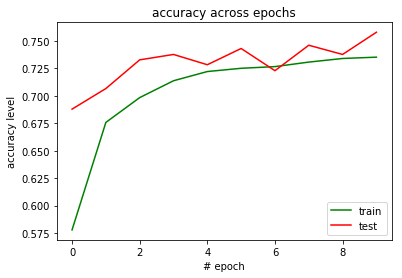

In [86]:
# show plot accuracy changes during training
plt.plot(history.history['acc'],'g')
plt.plot(history.history['val_acc'],'r')
plt.title('accuracy across epochs')
plt.ylabel('accuracy level')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [87]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
Y_pred = model.predict_classes(X_test)
Y_test = Y_test.reshape(Y_test.shape[0],1)
print(classification_report(Y_test, Y_pred))

5184/5184 [==============================] - 3s 571us/step
acc: 75.27%
             precision    recall  f1-score   support

          0       0.68      0.95      0.79      2570
          1       0.92      0.56      0.70      2614

avg / total       0.80      0.75      0.74      5184



This is interesting result: 
- The overall accuracy (73,53%) is good, but not impressive. 
- However, results for class 1 (disks that "failed soon" so within our predict_failure_days window) are quite interesting
- Precision equal to 91% means that once our model predicts disk will "fail soon" it is correct roughly in 9 out of 10 cases
- Recall equal to 50% means that we are able to identify half of failed disk from the whole pool of failed disks. The other half will go undetected.

The resuls is still fairly acceptable for everyday business use. Even if we can detect only hald of failed disks, our model is definitely quite precise in failure prediction.
NOTE: Remember this is machine learning (statistical) model. Your results can differ from mine to some extent.

Now we will play with our network to predict a few individual samples. You can re-run this cell manually as it select random disk from train set.

In [89]:
radom_index = randrange(0,X_test.shape[0])
num_samples = 20
print ("Random disks: \n",IDX_test[radom_index:radom_index+num_samples,:])
print ("Y_test (real flags)        ",Y_test[radom_index:radom_index+num_samples,:][:,0])
X_test_sample = X_test[radom_index:radom_index+num_samples,:,:]
Y_pred_sample = model.predict_classes(X_test_sample)[:,0]
print ("Y_predict (predicted flags)",Y_pred_sample)

Random disks: 
 [[Timestamp('2015-12-20 00:00:00') 'Z300K99Q']
 [Timestamp('2015-04-11 00:00:00') 'Z3011WD7']
 [Timestamp('2016-10-03 00:00:00') 'S300Z4EB']
 [Timestamp('2016-07-04 00:00:00') 'Z305CKQX']
 [Timestamp('2015-12-20 00:00:00') 'Z304HS1X']
 [Timestamp('2016-07-25 00:00:00') 'Z3029FA4']
 [Timestamp('2016-01-24 00:00:00') 'Z3025Z3Q']
 [Timestamp('2015-05-17 00:00:00') 'W300R7RG']
 [Timestamp('2015-12-22 00:00:00') 'W3005PYL']
 [Timestamp('2016-01-07 00:00:00') 'Z302FZTY']
 [Timestamp('2017-05-10 00:00:00') 'W300H3HK']
 [Timestamp('2016-09-20 00:00:00') 'Z305D22K']
 [Timestamp('2015-03-11 00:00:00') 'Z302AYP0']
 [Timestamp('2017-05-25 00:00:00') 'Z300XGKG']
 [Timestamp('2017-10-28 00:00:00') 'Z3015CB6']
 [Timestamp('2017-12-04 00:00:00') 'Z305G3NP']
 [Timestamp('2017-02-07 00:00:00') 'Z300ZT4T']
 [Timestamp('2017-10-21 00:00:00') 'Z300JDZC']
 [Timestamp('2017-05-12 00:00:00') 'Z302FDDC']
 [Timestamp('2015-09-30 00:00:00') 'Z3029GYZ']]
Y_test (real flags)         [0 0 0 1 0 1 1 